# Importing Libraries

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
#from flax import linen as nn
#from flax.training import train_state
#import optax
import pandas as pd

# Data Preprocessing

In [ ]:
import os
from natsort import natsorted

# Path to main folder containing all subfolders
main_folder = "/Users/ritwikvashistha/Downloads/mic1_renamed_trim_2"

# First, get the subfolders in a natural-sorted list
# (in case your subfolders also have numeric components in their names)
subfolders = [
    f for f in os.listdir(main_folder)
    if os.path.isdir(os.path.join(main_folder, f))
]
subfolders = natsorted(subfolders)

all_wavs = []  # to collect (filepath, sr, data) or similar

for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)

    # List .wav files in subfolder
    wav_files = [
        f for f in os.listdir(subfolder_path)
        if f.lower().endswith(".wav")
    ]
    # Sort them in natural order
    wav_files = natsorted(wav_files)

    # Process each .wav file
    for wav_file in wav_files:
        wav_path = os.path.join(subfolder_path, wav_file)

        # for example, using librosa (just as a placeholder)
        # import librosa
        # data, sr = librosa.load(wav_path, sr=None)

        # or using scipy
        sr, data = wavfile.read(wav_path)

        # collect or do something with the data
        all_wavs.append((wav_path, sr, data))

In [ ]:
import pandas as pd
meta_participant = pd.read_csv('/Users/ritwikvashistha/Downloads/meta_participant.csv')
meta_audio = pd.read_csv('/Users/ritwikvashistha/Downloads/meta_audio.csv')

In [ ]:
def pad_audio(audio_list, max_length):
    padded_audio = []
    masks = []
    for audio in audio_list:
        padding_length = max_length - len(audio)
        padded_audio.append(np.pad(audio, (0, padding_length), 'constant'))
        mask = np.ones(max_length)
        mask[len(audio):] = 0
        masks.append(mask)
    return np.array(padded_audio), np.array(masks)

In [ ]:
filtered_indices = meta_audio[meta_audio['ACTION LABEL'].isin([0, 1, 2])].index
filtered_wavs = [all_wavs[i] for i in filtered_indices]

In [ ]:
data_list = [item[2] for item in filtered_wavs]
max_length = 0
for data in data_list:
  max_length = max(max_length, len(data))
padded_audio, masks = pad_audio(data_list, max_length)

In [ ]:
# prompt: save padded_audio and masks

import numpy as np

np.save('padded_audio.npy', padded_audio)
np.save('masks.npy', masks)

In [ ]:
# prompt: import padded_audio.npy and masks.npy from drive

import numpy as np
from google.colab import drive
drive.mount('/content/drive')

padded_audio = np.load('/content/drive/My Drive/padded_audio.npy') #replace with your file path
masks = np.load('/content/drive/My Drive/masks.npy') #replace with your file path

print(padded_audio.shape)
masks.shape

Mounted at /content/drive
(5764, 94080)


(5764, 94080)

In [ ]:
meta_audio = pd.read_csv('/content/drive/My Drive/meta_audio.csv')
meta_participant = pd.read_csv('/content/drive/My Drive/meta_participant.csv')

,UTTNUM,UTTID,PAIN LEVEL,REVISED PAIN,DURATION (SEC),ACTION LABEL
count,7044.000000,7044.000000,7039.000000,7039.000000,7044.000000,7039.000000
mean,19.206275,18447.093555,3.246484,3.259980,2.651073,0.813894
std,11.305707,38689.981249,2.651474,2.637421,0.574915,1.233715
min,1.000000,0.000000,0.000000,1.000000,0.330000,0.000000
25%,9.000000,57.000000,1.000000,1.000000,2.310000,0.000000
50%,19.000000,117.000000,2.000000,2.000000,2.580000,0.000000
75%,29.000000,173.000000,5.000000,5.000000,2.970000,2.000000
max,45.000000,99999.000000,10.000000,10.000000,5.880000,4.000000


In [ ]:
participant_data= meta_participant.loc[meta_participant.index.repeat(meta_participant["NUMBER OF FILES"])]

# 3. Reset the index (optional, but usually helpful)
participant_data.reset_index(drop=True, inplace=True)
# Merge meta_audio and participant_data DataFrames
merged_df = pd.merge(meta_audio, participant_data, left_index=True, right_index=True)
mereged_df = merged_df[merged_df['ACTION LABEL'].isin([0, 1, 2])]

In [ ]:
labels = merged_df.loc[:,'REVISED PAIN']
labels= np.array([0 if x < 4 else 1 for x in labels]) # Labels: 0 or 1 for "No Pain"/"Pain"

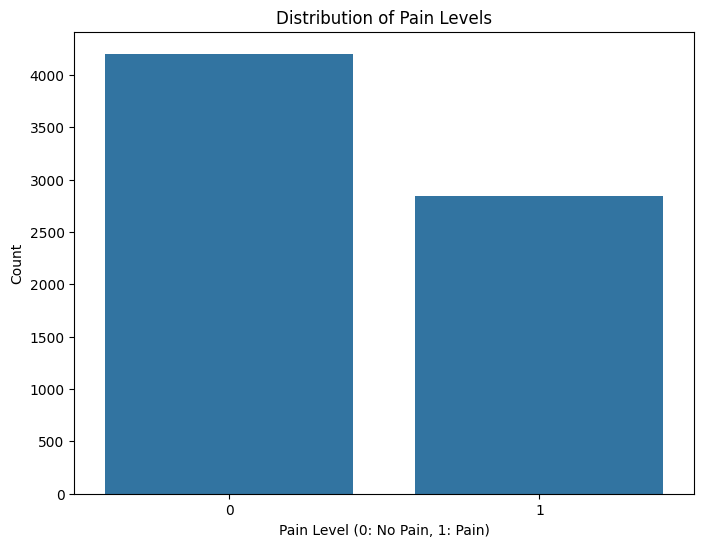

In [ ]:
# prompt: plot  barplot of labels

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'labels' is your NumPy array of labels (0 or 1)
unique_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=counts)
plt.xlabel("Pain Level (0: No Pain, 1: Pain)")
plt.ylabel("Count")
plt.title("Distribution of Pain Levels")
plt.show()


In [ ]:
tabular_data = merged_df.loc[:, ['GENDER', 'AGE', 'RACE/ETHNICITY', 'TOTAL DURATION (SEC)']]
tabular_data = pd.get_dummies(tabular_data, columns=['GENDER', 'RACE/ETHNICITY'], dtype=np.float32)
num_tab_features = tabular_data.shape[1]

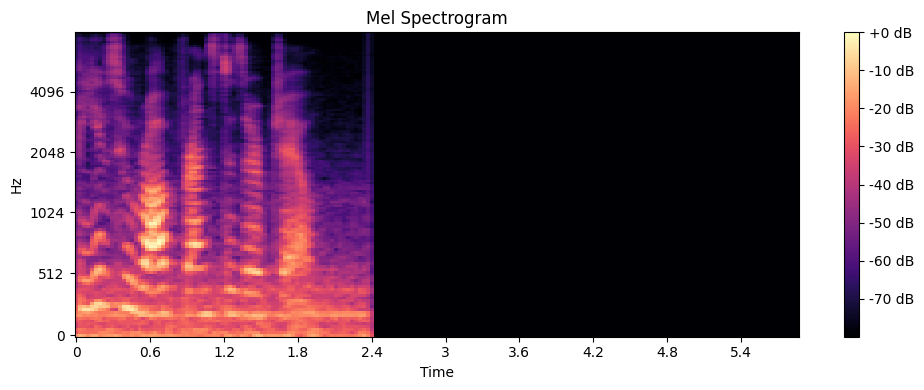

In [ ]:
# prompt: find mel spectogram of padded audio files in padded_audio

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def calculate_mel_spectrogram(audio_data, sr):
  mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)  # Adjust n_mels as needed
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
  return log_mel_spectrogram


# Assuming 'padded_audio' and 'masks' are already loaded as numpy arrays

# Example usage for the first audio file

audio_data = padded_audio[1].astype(np.float32)
sr = 16000 # Replace with the actual sample rate of your audio files

mel_spectrogram = calculate_mel_spectrogram(audio_data, sr)


# Displaying the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()




In [ ]:
mel_spectrograms = []
for i in range(len(padded_audio)):
  audio_data = padded_audio[i].astype(np.float32)
  mel_spectrogram = calculate_mel_spectrogram(audio_data, sr)
  mel_spectrograms.append(mel_spectrogram)

# mel_spectrograms is now a list of mel spectrograms for each audio file
print(len(mel_spectrograms))
mel_spectrograms[0].shape

5764


(128, 184)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Convert mel spectrograms to PyTorch tensors
mel_spectrograms_tensor = torch.tensor(np.array(mel_spectrograms).reshape((5764, 1, 128, 184)))
labels_tensor = torch.tensor(labels)
# Now, try converting to tensor
tabular_data_tensor = torch.tensor(tabular_data.values, dtype=torch.float32)


train_indices = np.random.choice(len(mel_spectrograms_tensor), size=int(0.7 * len(mel_spectrograms_tensor)), replace=False)
test_indices = np.array(list(set(range(len(mel_spectrograms_tensor))) - set(train_indices)))


In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

def create_masks(spectrograms):
    """
    Creates binary masks for spectrograms where non-zero elements are marked as 1.

    Args:
        spectrograms (torch.Tensor): Tensor of shape (N, 1, 128, 184).

    Returns:
        torch.Tensor: Binary masks of the same shape.
    """
    masks = (spectrograms != 0).float()
    return masks

class MultimodalDataset(Dataset):
    def __init__(self, spectrograms, tabular_features, labels=None):
        """
        Initializes the dataset.

        Args:
            spectrograms (torch.Tensor): Tensor of shape (N, 1, 128, 184).
            tabular_features (torch.Tensor): Tensor of shape (N, 11).
            labels (torch.Tensor, optional): Tensor of shape (N,). Defaults to None.
        """
        assert spectrograms.size(0) == tabular_features.size(0), "Mismatch in number of samples."
        if labels is not None:
            assert spectrograms.size(0) == labels.size(0), "Mismatch in number of samples."
        self.spectrograms = spectrograms
        self.tabular_features = tabular_features
        self.labels = labels

    def __len__(self):
        return self.spectrograms.size(0)

    def __getitem__(self, idx):
        spect = self.spectrograms[idx]
        tabular = self.tabular_features[idx]
        mask = create_masks(spect.unsqueeze(0)).squeeze(0)  # Shape: (1, 128, 184)
        if self.labels is not None:
            label = self.labels[idx]
            return spect, tabular, mask, label
        else:
            return spect, tabular, mask

# Example: Creating a DataLoader with masks
def create_multimodal_loader(spectrograms, tabular_features, labels, batch_size=32, shuffle=True):
    dataset = MultimodalDataset(spectrograms, tabular_features, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader


# Instantiate the DataLoader
train_loader = create_multimodal_loader(mel_spectrograms_tensor[train_indices],tabular_data_tensor[train_indices],labels_tensor[train_indices], batch_size=32, shuffle=True)
test_loader = create_multimodal_loader(mel_spectrograms_tensor[test_indices] ,tabular_data_tensor[test_indices], labels_tensor[test_indices], batch_size=32, shuffle=False)


# Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from collections import OrderedDict

import torch.nn as nn
from collections import OrderedDict

# Assuming FrequencyAutoencoder and LSTMClassifier are defined as before

class FrequencyAutoencoder(nn.Module):
    def __init__(self, latent_ch=8, dropout_p=0.1):
        super(FrequencyAutoencoder, self).__init__()
        self.first = True

        self.filters = [1, 16, latent_ch]
        self.kernel_sizes = [(4, 4), (4, 4)]
        self.strides = [(2, 2), (2, 2)]
        self.paddings = [(1, 1), (1, 1)]

        # ENCODER
        self.encoder_model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.filters[0], self.filters[1],
                                kernel_size=self.kernel_sizes[0],
                                stride=self.strides[0],
                                padding=self.paddings[0])),
            ('relu1', nn.ReLU(inplace=True)),
            ('dropout1', nn.Dropout2d(p=dropout_p)),  # <-- Dropout2d for spatial dropout in 2D conv

            ('conv2', nn.Conv2d(self.filters[1], self.filters[2],
                                kernel_size=self.kernel_sizes[1],
                                stride=self.strides[1],
                                padding=self.paddings[1])),
            ('relu2', nn.ReLU(inplace=True)),
            ('dropout2', nn.Dropout2d(p=dropout_p)),  # <-- Another dropout
        ]))

        # DECODER
        # You might or might not add dropout in the decoder. Typically less common,
        # but you can if you want to regularize the entire autoencoder.
        self.decoder_model = nn.Sequential(OrderedDict([
            ('convT2', nn.ConvTranspose2d(self.filters[2], self.filters[1],
                                          kernel_size=self.kernel_sizes[1],
                                          stride=self.strides[1],
                                          padding=self.paddings[1])),
            ('reluT2', nn.ReLU(inplace=True)),
            # Optionally dropout here, but let's keep it simple

            ('convT1', nn.ConvTranspose2d(self.filters[1], self.filters[0],
                                          kernel_size=self.kernel_sizes[0],
                                          stride=self.strides[0],
                                          padding=self.paddings[0])),
        ]))

        self.loss_criterion = nn.MSELoss()

    def forward(self, inputs):
        encoded_data = self.encoder_model(inputs)
        decoded_data = self.decoder_model(encoded_data)

        ...
        return decoded_data, encoded_data

import torch.nn as nn

class MLPClassifier(nn.Module):
    """
    MLP-based Classifier for combined latent representations with Dropout.
    """
    def __init__(self, input_dim=256, hidden_dims=[128, 64], num_classes=10, dropout_p=0.5):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))

            # Insert Dropout after the activation
            layers.append(nn.Dropout(p=dropout_p))

            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, combined_latent):
        return self.model(combined_latent)


class AutoencoderWithClassifierMultimodal(nn.Module):
    """
    Combined model of the autoencoder and the classifier for multimodal data.
    """
    def __init__(self, autoencoder, classifier):
        super(AutoencoderWithClassifierMultimodal, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x_audio, x_tabular):
        # Pass through the autoencoder
        reconstructed, latent_audio = self.autoencoder(x_audio)  # latent_audio shape: (B, 8, 32, 46)

        # Flatten the audio latent
        latent_audio_flat = latent_audio.view(latent_audio.size(0), -1)  # Shape: (B, 8*32*46) = (B, 11776)

        # Concatenate with tabular features
        combined_latent = torch.cat((latent_audio_flat, x_tabular), dim=1)  # Shape: (B, 11776 + 11) = (B, 11787)

        # Pass the combined latent features to the classifier
        class_logits = self.classifier(combined_latent)  # Shape: (B, num_classes)

        return reconstructed, class_logits

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()
        self.mse = nn.MSELoss(reduction='none')  # Compute element-wise MSE

    def forward(self, recon, target, mask):
        """
        Computes the masked MSE loss.

        Args:
            recon (torch.Tensor): Reconstructed spectrograms. Shape: (B, 1, 128, 184)
            target (torch.Tensor): Original spectrograms. Shape: (B, 1, 128, 184)
            mask (torch.Tensor): Masks indicating valid regions. Shape: (B, 1, 128, 184)

        Returns:
            torch.Tensor: Scalar loss value.
        """
        loss = self.mse(recon, target)  # Shape: (B, 1, 128, 184)
        loss = loss * mask  # Apply mask
        return loss.sum() / mask.sum()  # Average loss over valid regions


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars


def train_autoencoder_classifier_multimodal(model, train_loader, num_epochs=20, lr=1e-3, device='cuda'):
    """
    Trains the combined autoencoder and classifier model with masking and multimodal data.

    Args:
        model (nn.Module): Combined autoencoder and classifier model.
        train_loader (DataLoader): DataLoader yielding (spectrogram, tabular_features, mask, label) batches.
        num_epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.
        device (str): Device to train on ('cuda' or 'cpu').

    Returns:
        model (nn.Module): Trained model.
        history (dict): Training history containing loss and accuracy.
    """
    model.to(device)

    # Define optimizer to update all parameters
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define loss criteria
    reconstruction_criterion = MaskedMSELoss()
    classification_criterion = nn.CrossEntropyLoss()

    # To store loss and accuracy
    history = {
        'reconstruction_loss': [],
        'classification_loss': [],
        'accuracy': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_recon_loss = 0.0
        running_class_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm for a progress bar
        loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]')

        for batch_idx, (batch_spect, batch_tabular, mask, labels) in enumerate(loop):
            # Move data to device
            batch_spect = batch_spect.to(device, non_blocking=True)
            batch_tabular = batch_tabular.to(device, non_blocking=True)
            mask = mask.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            reconstructed, class_logits = model(batch_spect, batch_tabular)

            # Compute losses
            recon_loss = reconstruction_criterion(reconstructed, batch_spect, mask)
            class_loss = classification_criterion(class_logits, labels)
            total_loss = recon_loss + class_loss  # Adjust weighting if necessary

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            # Accumulate losses
            running_recon_loss += recon_loss.item() * batch_spect.size(0)
            running_class_loss += class_loss.item() * batch_spect.size(0)

            # Compute accuracy
            _, predicted = torch.max(class_logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            loop.set_postfix({
                'Reconstruction Loss': recon_loss.item(),
                'Classification Loss': class_loss.item(),
                'Accuracy': f"{100 * correct / total:.2f}%"
            })

        # Compute average losses and accuracy for the epoch
        epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
        epoch_class_loss = running_class_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total

        # Store in history
        history['reconstruction_loss'].append(epoch_recon_loss)
        history['classification_loss'].append(epoch_class_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Reconstruction Loss: {epoch_recon_loss:.6f} "
              f"Classification Loss: {epoch_class_loss:.6f} "
              f"Accuracy: {epoch_accuracy:.2f}%")

    return model, history


In [ ]:
def plot_training_history(history):
    """
    Plots reconstruction loss, classification loss, and accuracy over epochs.

    Args:
        history (dict): Training history containing loss and accuracy.
    """
    epochs = range(1, len(history['reconstruction_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # Plot Reconstruction Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['reconstruction_loss'], 'r-', label='Reconstruction Loss')
    plt.title('Reconstruction Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)

    # Plot Classification Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['classification_loss'], 'b-', label='Classification Loss')
    plt.title('Classification Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('CrossEntropy Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Model Training

In [ ]:
autoencoder = FrequencyAutoencoder(latent_ch=8)
classifier = MLPClassifier(input_dim=11787, hidden_dims=[128, 64], num_classes=2)  # Adjust input_dim
# Combined Model with Projection Layer
combined_model = AutoencoderWithClassifierMultimodal(autoencoder, classifier)

num_epochs = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trained_model, training_history = train_autoencoder_classifier_multimodal(
    model=combined_model,
    train_loader=train_loader,
    num_epochs=num_epochs,
    lr=learning_rate,
    device=device
)


Epoch [1/100]: 100%|██████████| 127/127 [00:03<00:00, 34.70it/s, Reconstruction Loss=180, Classification Loss=0.677, Accuracy=55.23%]


Epoch [1/100] Reconstruction Loss: 885.869263 Classification Loss: 0.717571 Accuracy: 55.23%


Epoch [2/100]: 100%|██████████| 127/127 [00:01<00:00, 65.21it/s, Reconstruction Loss=76.3, Classification Loss=0.682, Accuracy=56.79%]


Epoch [2/100] Reconstruction Loss: 149.152509 Classification Loss: 0.691247 Accuracy: 56.79%


Epoch [3/100]: 100%|██████████| 127/127 [00:01<00:00, 66.65it/s, Reconstruction Loss=44.5, Classification Loss=0.54, Accuracy=59.10%]


Epoch [3/100] Reconstruction Loss: 85.158783 Classification Loss: 0.680845 Accuracy: 59.10%


Epoch [4/100]: 100%|██████████| 127/127 [00:01<00:00, 67.73it/s, Reconstruction Loss=30, Classification Loss=0.612, Accuracy=58.97%]


Epoch [4/100] Reconstruction Loss: 60.854988 Classification Loss: 0.681117 Accuracy: 58.97%


Epoch [5/100]: 100%|██████████| 127/127 [00:01<00:00, 66.95it/s, Reconstruction Loss=17.9, Classification Loss=0.929, Accuracy=58.97%]


Epoch [5/100] Reconstruction Loss: 49.423847 Classification Loss: 0.680649 Accuracy: 58.97%


Epoch [6/100]: 100%|██████████| 127/127 [00:02<00:00, 58.27it/s, Reconstruction Loss=31.4, Classification Loss=0.769, Accuracy=59.32%]


Epoch [6/100] Reconstruction Loss: 43.115242 Classification Loss: 0.676872 Accuracy: 59.32%


Epoch [7/100]: 100%|██████████| 127/127 [00:02<00:00, 53.80it/s, Reconstruction Loss=27.1, Classification Loss=0.905, Accuracy=59.42%]


Epoch [7/100] Reconstruction Loss: 38.052089 Classification Loss: 0.678049 Accuracy: 59.42%


Epoch [8/100]: 100%|██████████| 127/127 [00:02<00:00, 57.60it/s, Reconstruction Loss=18.9, Classification Loss=0.501, Accuracy=59.57%]


Epoch [8/100] Reconstruction Loss: 36.922223 Classification Loss: 0.677218 Accuracy: 59.57%


Epoch [9/100]: 100%|██████████| 127/127 [00:01<00:00, 65.05it/s, Reconstruction Loss=15.5, Classification Loss=0.604, Accuracy=59.12%]


Epoch [9/100] Reconstruction Loss: 27.866724 Classification Loss: 0.677269 Accuracy: 59.12%


Epoch [10/100]: 100%|██████████| 127/127 [00:01<00:00, 63.55it/s, Reconstruction Loss=15.4, Classification Loss=1, Accuracy=59.15%]


Epoch [10/100] Reconstruction Loss: 26.998233 Classification Loss: 0.678075 Accuracy: 59.15%


Epoch [11/100]: 100%|██████████| 127/127 [00:01<00:00, 63.79it/s, Reconstruction Loss=9.54, Classification Loss=0.867, Accuracy=59.32%]


Epoch [11/100] Reconstruction Loss: 26.347629 Classification Loss: 0.676912 Accuracy: 59.32%


Epoch [12/100]: 100%|██████████| 127/127 [00:01<00:00, 64.10it/s, Reconstruction Loss=28.3, Classification Loss=0.807, Accuracy=59.35%]


Epoch [12/100] Reconstruction Loss: 24.710936 Classification Loss: 0.676512 Accuracy: 59.35%


Epoch [13/100]: 100%|██████████| 127/127 [00:02<00:00, 56.80it/s, Reconstruction Loss=14.7, Classification Loss=0.462, Accuracy=59.49%]


Epoch [13/100] Reconstruction Loss: 22.446872 Classification Loss: 0.677622 Accuracy: 59.49%


Epoch [14/100]: 100%|██████████| 127/127 [00:02<00:00, 50.87it/s, Reconstruction Loss=15, Classification Loss=1.04, Accuracy=59.49%]


Epoch [14/100] Reconstruction Loss: 20.233736 Classification Loss: 0.677032 Accuracy: 59.49%


Epoch [15/100]: 100%|██████████| 127/127 [00:02<00:00, 58.37it/s, Reconstruction Loss=13, Classification Loss=0.509, Accuracy=59.42%]


Epoch [15/100] Reconstruction Loss: 18.763932 Classification Loss: 0.678171 Accuracy: 59.42%


Epoch [16/100]: 100%|██████████| 127/127 [00:01<00:00, 65.07it/s, Reconstruction Loss=10, Classification Loss=0.728, Accuracy=59.59%]


Epoch [16/100] Reconstruction Loss: 18.879045 Classification Loss: 0.676245 Accuracy: 59.59%


Epoch [17/100]: 100%|██████████| 127/127 [00:01<00:00, 64.93it/s, Reconstruction Loss=8.81, Classification Loss=0.477, Accuracy=59.52%]


Epoch [17/100] Reconstruction Loss: 16.514327 Classification Loss: 0.676802 Accuracy: 59.52%


Epoch [18/100]: 100%|██████████| 127/127 [00:01<00:00, 63.72it/s, Reconstruction Loss=11.5, Classification Loss=0.654, Accuracy=59.52%]


Epoch [18/100] Reconstruction Loss: 16.367096 Classification Loss: 0.674631 Accuracy: 59.52%


Epoch [19/100]: 100%|██████████| 127/127 [00:01<00:00, 66.64it/s, Reconstruction Loss=9.16, Classification Loss=0.767, Accuracy=59.47%]


Epoch [19/100] Reconstruction Loss: 15.119462 Classification Loss: 0.676983 Accuracy: 59.47%


Epoch [20/100]: 100%|██████████| 127/127 [00:02<00:00, 57.92it/s, Reconstruction Loss=11.9, Classification Loss=0.852, Accuracy=59.35%]


Epoch [20/100] Reconstruction Loss: 14.906204 Classification Loss: 0.676271 Accuracy: 59.35%


Epoch [21/100]: 100%|██████████| 127/127 [00:02<00:00, 52.21it/s, Reconstruction Loss=13.2, Classification Loss=0.765, Accuracy=59.32%]


Epoch [21/100] Reconstruction Loss: 14.088563 Classification Loss: 0.677027 Accuracy: 59.32%


Epoch [22/100]: 100%|██████████| 127/127 [00:02<00:00, 61.45it/s, Reconstruction Loss=7.73, Classification Loss=0.53, Accuracy=59.40%]


Epoch [22/100] Reconstruction Loss: 14.278674 Classification Loss: 0.676500 Accuracy: 59.40%


Epoch [23/100]: 100%|██████████| 127/127 [00:02<00:00, 62.80it/s, Reconstruction Loss=10.2, Classification Loss=0.557, Accuracy=59.47%]


Epoch [23/100] Reconstruction Loss: 13.941124 Classification Loss: 0.677413 Accuracy: 59.47%


Epoch [24/100]: 100%|██████████| 127/127 [00:01<00:00, 63.94it/s, Reconstruction Loss=10.2, Classification Loss=0.62, Accuracy=59.52%]


Epoch [24/100] Reconstruction Loss: 15.051522 Classification Loss: 0.675886 Accuracy: 59.52%


Epoch [25/100]: 100%|██████████| 127/127 [00:02<00:00, 63.21it/s, Reconstruction Loss=7.89, Classification Loss=0.724, Accuracy=59.42%]


Epoch [25/100] Reconstruction Loss: 13.734149 Classification Loss: 0.676678 Accuracy: 59.42%


Epoch [26/100]: 100%|██████████| 127/127 [00:01<00:00, 66.41it/s, Reconstruction Loss=8.44, Classification Loss=0.703, Accuracy=59.52%]


Epoch [26/100] Reconstruction Loss: 12.432194 Classification Loss: 0.677029 Accuracy: 59.52%


Epoch [27/100]: 100%|██████████| 127/127 [00:02<00:00, 53.93it/s, Reconstruction Loss=7.84, Classification Loss=0.561, Accuracy=59.47%]


Epoch [27/100] Reconstruction Loss: 14.158836 Classification Loss: 0.676634 Accuracy: 59.47%


Epoch [28/100]: 100%|██████████| 127/127 [00:02<00:00, 51.10it/s, Reconstruction Loss=25.8, Classification Loss=0.511, Accuracy=59.54%]


Epoch [28/100] Reconstruction Loss: 12.872329 Classification Loss: 0.674526 Accuracy: 59.54%


Epoch [29/100]: 100%|██████████| 127/127 [00:02<00:00, 57.79it/s, Reconstruction Loss=13.5, Classification Loss=0.682, Accuracy=59.47%]


Epoch [29/100] Reconstruction Loss: 11.952686 Classification Loss: 0.675148 Accuracy: 59.47%


Epoch [30/100]: 100%|██████████| 127/127 [00:02<00:00, 62.05it/s, Reconstruction Loss=5.85, Classification Loss=0.828, Accuracy=59.40%]


Epoch [30/100] Reconstruction Loss: 11.810762 Classification Loss: 0.675341 Accuracy: 59.40%


Epoch [31/100]: 100%|██████████| 127/127 [00:01<00:00, 63.64it/s, Reconstruction Loss=6.87, Classification Loss=0.934, Accuracy=59.47%]


Epoch [31/100] Reconstruction Loss: 11.272552 Classification Loss: 0.676600 Accuracy: 59.47%


Epoch [32/100]: 100%|██████████| 127/127 [00:02<00:00, 62.67it/s, Reconstruction Loss=8.78, Classification Loss=0.777, Accuracy=59.47%]


Epoch [32/100] Reconstruction Loss: 11.184835 Classification Loss: 0.675248 Accuracy: 59.47%


Epoch [33/100]: 100%|██████████| 127/127 [00:02<00:00, 61.45it/s, Reconstruction Loss=4.78, Classification Loss=0.636, Accuracy=59.54%]


Epoch [33/100] Reconstruction Loss: 11.166230 Classification Loss: 0.675007 Accuracy: 59.54%


Epoch [34/100]: 100%|██████████| 127/127 [00:02<00:00, 49.89it/s, Reconstruction Loss=6.19, Classification Loss=0.511, Accuracy=59.49%]


Epoch [34/100] Reconstruction Loss: 11.828039 Classification Loss: 0.675523 Accuracy: 59.49%


Epoch [35/100]: 100%|██████████| 127/127 [00:02<00:00, 49.86it/s, Reconstruction Loss=16.1, Classification Loss=0.91, Accuracy=59.54%]


Epoch [35/100] Reconstruction Loss: 10.824317 Classification Loss: 0.672507 Accuracy: 59.54%


Epoch [36/100]: 100%|██████████| 127/127 [00:02<00:00, 62.51it/s, Reconstruction Loss=8.42, Classification Loss=0.637, Accuracy=59.32%]


Epoch [36/100] Reconstruction Loss: 11.428896 Classification Loss: 0.675391 Accuracy: 59.32%


Epoch [37/100]: 100%|██████████| 127/127 [00:01<00:00, 64.12it/s, Reconstruction Loss=6.12, Classification Loss=0.988, Accuracy=59.67%]


Epoch [37/100] Reconstruction Loss: 11.925317 Classification Loss: 0.672381 Accuracy: 59.67%


Epoch [38/100]: 100%|██████████| 127/127 [00:01<00:00, 63.92it/s, Reconstruction Loss=8.87, Classification Loss=0.518, Accuracy=59.15%]


Epoch [38/100] Reconstruction Loss: 11.937945 Classification Loss: 0.672444 Accuracy: 59.15%


Epoch [39/100]: 100%|██████████| 127/127 [00:02<00:00, 62.95it/s, Reconstruction Loss=8.79, Classification Loss=0.84, Accuracy=59.42%]


Epoch [39/100] Reconstruction Loss: 10.518959 Classification Loss: 0.671184 Accuracy: 59.42%


Epoch [40/100]: 100%|██████████| 127/127 [00:02<00:00, 56.92it/s, Reconstruction Loss=15, Classification Loss=0.73, Accuracy=59.52%]


Epoch [40/100] Reconstruction Loss: 11.962078 Classification Loss: 0.670668 Accuracy: 59.52%


Epoch [41/100]: 100%|██████████| 127/127 [00:02<00:00, 48.61it/s, Reconstruction Loss=8.79, Classification Loss=0.577, Accuracy=59.44%]


Epoch [41/100] Reconstruction Loss: 12.853984 Classification Loss: 0.673679 Accuracy: 59.44%


Epoch [42/100]: 100%|██████████| 127/127 [00:02<00:00, 55.77it/s, Reconstruction Loss=6.62, Classification Loss=0.706, Accuracy=59.52%]


Epoch [42/100] Reconstruction Loss: 10.020371 Classification Loss: 0.672001 Accuracy: 59.52%


Epoch [43/100]: 100%|██████████| 127/127 [00:02<00:00, 63.27it/s, Reconstruction Loss=4.88, Classification Loss=0.562, Accuracy=59.37%]


Epoch [43/100] Reconstruction Loss: 9.719981 Classification Loss: 0.671518 Accuracy: 59.37%


Epoch [44/100]: 100%|██████████| 127/127 [00:02<00:00, 62.73it/s, Reconstruction Loss=15.8, Classification Loss=0.734, Accuracy=59.69%]


Epoch [44/100] Reconstruction Loss: 10.389257 Classification Loss: 0.672718 Accuracy: 59.69%


Epoch [45/100]: 100%|██████████| 127/127 [00:02<00:00, 61.20it/s, Reconstruction Loss=6.45, Classification Loss=0.987, Accuracy=59.40%]


Epoch [45/100] Reconstruction Loss: 9.908895 Classification Loss: 0.668729 Accuracy: 59.40%


Epoch [46/100]: 100%|██████████| 127/127 [00:02<00:00, 62.29it/s, Reconstruction Loss=9.02, Classification Loss=0.478, Accuracy=59.57%]


Epoch [46/100] Reconstruction Loss: 9.822525 Classification Loss: 0.669067 Accuracy: 59.57%


Epoch [47/100]: 100%|██████████| 127/127 [00:02<00:00, 55.44it/s, Reconstruction Loss=6.26, Classification Loss=0.524, Accuracy=60.16%]


Epoch [47/100] Reconstruction Loss: 10.173740 Classification Loss: 0.666759 Accuracy: 60.16%


Epoch [48/100]: 100%|██████████| 127/127 [00:02<00:00, 50.46it/s, Reconstruction Loss=7.2, Classification Loss=0.751, Accuracy=59.57%]


Epoch [48/100] Reconstruction Loss: 11.169910 Classification Loss: 0.668877 Accuracy: 59.57%


Epoch [49/100]: 100%|██████████| 127/127 [00:02<00:00, 60.14it/s, Reconstruction Loss=25.9, Classification Loss=0.56, Accuracy=59.59%]


Epoch [49/100] Reconstruction Loss: 9.888869 Classification Loss: 0.668699 Accuracy: 59.59%


Epoch [50/100]: 100%|██████████| 127/127 [00:01<00:00, 64.16it/s, Reconstruction Loss=7.82, Classification Loss=1.03, Accuracy=59.67%]


Epoch [50/100] Reconstruction Loss: 10.217537 Classification Loss: 0.666177 Accuracy: 59.67%


Epoch [51/100]: 100%|██████████| 127/127 [00:01<00:00, 63.71it/s, Reconstruction Loss=9.46, Classification Loss=0.474, Accuracy=59.32%]


Epoch [51/100] Reconstruction Loss: 9.975956 Classification Loss: 0.668048 Accuracy: 59.32%


Epoch [52/100]: 100%|██████████| 127/127 [00:02<00:00, 62.93it/s, Reconstruction Loss=15.9, Classification Loss=0.476, Accuracy=60.11%]


Epoch [52/100] Reconstruction Loss: 9.581351 Classification Loss: 0.666629 Accuracy: 60.11%


Epoch [53/100]: 100%|██████████| 127/127 [00:01<00:00, 64.98it/s, Reconstruction Loss=10.8, Classification Loss=0.464, Accuracy=60.73%]


Epoch [53/100] Reconstruction Loss: 9.559001 Classification Loss: 0.665944 Accuracy: 60.73%


Epoch [54/100]: 100%|██████████| 127/127 [00:02<00:00, 52.76it/s, Reconstruction Loss=3.56, Classification Loss=1.12, Accuracy=60.01%]


Epoch [54/100] Reconstruction Loss: 9.554332 Classification Loss: 0.662580 Accuracy: 60.01%


Epoch [55/100]: 100%|██████████| 127/127 [00:02<00:00, 47.78it/s, Reconstruction Loss=11.9, Classification Loss=0.669, Accuracy=59.64%]


Epoch [55/100] Reconstruction Loss: 8.575582 Classification Loss: 0.662866 Accuracy: 59.64%


Epoch [56/100]: 100%|██████████| 127/127 [00:02<00:00, 62.10it/s, Reconstruction Loss=4.53, Classification Loss=0.476, Accuracy=59.47%]


Epoch [56/100] Reconstruction Loss: 9.103200 Classification Loss: 0.665882 Accuracy: 59.47%


Epoch [57/100]: 100%|██████████| 127/127 [00:02<00:00, 62.38it/s, Reconstruction Loss=28.4, Classification Loss=0.588, Accuracy=60.61%]


Epoch [57/100] Reconstruction Loss: 9.713597 Classification Loss: 0.662088 Accuracy: 60.61%


Epoch [58/100]: 100%|██████████| 127/127 [00:01<00:00, 64.71it/s, Reconstruction Loss=5.57, Classification Loss=0.442, Accuracy=60.29%]


Epoch [58/100] Reconstruction Loss: 11.199335 Classification Loss: 0.662153 Accuracy: 60.29%


Epoch [59/100]: 100%|██████████| 127/127 [00:01<00:00, 64.70it/s, Reconstruction Loss=4.99, Classification Loss=0.475, Accuracy=60.73%]


Epoch [59/100] Reconstruction Loss: 9.640752 Classification Loss: 0.658233 Accuracy: 60.73%


Epoch [60/100]: 100%|██████████| 127/127 [00:02<00:00, 61.37it/s, Reconstruction Loss=7.91, Classification Loss=0.477, Accuracy=61.25%]


Epoch [60/100] Reconstruction Loss: 9.186283 Classification Loss: 0.659142 Accuracy: 61.25%


Epoch [61/100]: 100%|██████████| 127/127 [00:02<00:00, 54.08it/s, Reconstruction Loss=4.57, Classification Loss=0.521, Accuracy=61.16%]


Epoch [61/100] Reconstruction Loss: 9.693333 Classification Loss: 0.660159 Accuracy: 61.16%


Epoch [62/100]: 100%|██████████| 127/127 [00:02<00:00, 50.67it/s, Reconstruction Loss=5.69, Classification Loss=0.855, Accuracy=61.92%]


Epoch [62/100] Reconstruction Loss: 8.263861 Classification Loss: 0.656105 Accuracy: 61.92%


Epoch [63/100]: 100%|██████████| 127/127 [00:02<00:00, 61.85it/s, Reconstruction Loss=6.24, Classification Loss=1.08, Accuracy=61.60%]


Epoch [63/100] Reconstruction Loss: 8.976002 Classification Loss: 0.654276 Accuracy: 61.60%


Epoch [64/100]: 100%|██████████| 127/127 [00:02<00:00, 63.29it/s, Reconstruction Loss=6.92, Classification Loss=0.488, Accuracy=61.53%]


Epoch [64/100] Reconstruction Loss: 8.121191 Classification Loss: 0.653941 Accuracy: 61.53%


Epoch [65/100]: 100%|██████████| 127/127 [00:02<00:00, 62.33it/s, Reconstruction Loss=6.15, Classification Loss=0.483, Accuracy=61.20%]


Epoch [65/100] Reconstruction Loss: 8.539866 Classification Loss: 0.657829 Accuracy: 61.20%


Epoch [66/100]: 100%|██████████| 127/127 [00:02<00:00, 62.43it/s, Reconstruction Loss=8.45, Classification Loss=0.784, Accuracy=62.42%]


Epoch [66/100] Reconstruction Loss: 8.190981 Classification Loss: 0.650255 Accuracy: 62.42%


Epoch [67/100]: 100%|██████████| 127/127 [00:02<00:00, 60.72it/s, Reconstruction Loss=8.63, Classification Loss=0.983, Accuracy=61.11%]


Epoch [67/100] Reconstruction Loss: 7.835941 Classification Loss: 0.653283 Accuracy: 61.11%


Epoch [68/100]: 100%|██████████| 127/127 [00:02<00:00, 50.60it/s, Reconstruction Loss=7, Classification Loss=0.515, Accuracy=61.55%]


Epoch [68/100] Reconstruction Loss: 9.670774 Classification Loss: 0.654051 Accuracy: 61.55%


Epoch [69/100]: 100%|██████████| 127/127 [00:02<00:00, 50.45it/s, Reconstruction Loss=6.07, Classification Loss=0.889, Accuracy=62.42%]


Epoch [69/100] Reconstruction Loss: 9.144909 Classification Loss: 0.650280 Accuracy: 62.42%


Epoch [70/100]: 100%|██████████| 127/127 [00:01<00:00, 63.70it/s, Reconstruction Loss=6.74, Classification Loss=0.713, Accuracy=60.83%]


Epoch [70/100] Reconstruction Loss: 8.682632 Classification Loss: 0.647133 Accuracy: 60.83%


Epoch [71/100]: 100%|██████████| 127/127 [00:02<00:00, 63.09it/s, Reconstruction Loss=45.9, Classification Loss=0.903, Accuracy=61.11%]


Epoch [71/100] Reconstruction Loss: 9.053676 Classification Loss: 0.653747 Accuracy: 61.11%


Epoch [72/100]: 100%|██████████| 127/127 [00:01<00:00, 63.74it/s, Reconstruction Loss=3.28, Classification Loss=0.544, Accuracy=62.47%]


Epoch [72/100] Reconstruction Loss: 14.029355 Classification Loss: 0.645013 Accuracy: 62.47%


Epoch [73/100]: 100%|██████████| 127/127 [00:02<00:00, 61.81it/s, Reconstruction Loss=6.27, Classification Loss=0.594, Accuracy=61.80%]


Epoch [73/100] Reconstruction Loss: 9.168718 Classification Loss: 0.648075 Accuracy: 61.80%


Epoch [74/100]: 100%|██████████| 127/127 [00:02<00:00, 57.30it/s, Reconstruction Loss=12.2, Classification Loss=0.499, Accuracy=62.32%]


Epoch [74/100] Reconstruction Loss: 8.625360 Classification Loss: 0.646541 Accuracy: 62.32%


Epoch [75/100]: 100%|██████████| 127/127 [00:02<00:00, 49.65it/s, Reconstruction Loss=10.4, Classification Loss=0.546, Accuracy=62.67%]


Epoch [75/100] Reconstruction Loss: 9.078998 Classification Loss: 0.643443 Accuracy: 62.67%


Epoch [76/100]: 100%|██████████| 127/127 [00:02<00:00, 51.72it/s, Reconstruction Loss=8.79, Classification Loss=1.05, Accuracy=62.62%]


Epoch [76/100] Reconstruction Loss: 8.842196 Classification Loss: 0.642489 Accuracy: 62.62%


Epoch [77/100]: 100%|██████████| 127/127 [00:02<00:00, 63.29it/s, Reconstruction Loss=5.89, Classification Loss=0.489, Accuracy=63.73%]


Epoch [77/100] Reconstruction Loss: 8.471296 Classification Loss: 0.636930 Accuracy: 63.73%


Epoch [78/100]: 100%|██████████| 127/127 [00:02<00:00, 63.47it/s, Reconstruction Loss=6.6, Classification Loss=0.944, Accuracy=63.34%]


Epoch [78/100] Reconstruction Loss: 8.011972 Classification Loss: 0.642195 Accuracy: 63.34%


Epoch [79/100]: 100%|██████████| 127/127 [00:02<00:00, 62.94it/s, Reconstruction Loss=7.87, Classification Loss=0.511, Accuracy=63.86%]


Epoch [79/100] Reconstruction Loss: 7.967661 Classification Loss: 0.631393 Accuracy: 63.86%


Epoch [80/100]: 100%|██████████| 127/127 [00:02<00:00, 62.16it/s, Reconstruction Loss=7.73, Classification Loss=0.827, Accuracy=63.01%]


Epoch [80/100] Reconstruction Loss: 7.928032 Classification Loss: 0.644076 Accuracy: 63.01%


Epoch [81/100]: 100%|██████████| 127/127 [00:02<00:00, 57.69it/s, Reconstruction Loss=5.78, Classification Loss=0.466, Accuracy=63.14%]


Epoch [81/100] Reconstruction Loss: 7.987772 Classification Loss: 0.637278 Accuracy: 63.14%


Epoch [82/100]: 100%|██████████| 127/127 [00:02<00:00, 48.41it/s, Reconstruction Loss=13.6, Classification Loss=0.508, Accuracy=63.76%]


Epoch [82/100] Reconstruction Loss: 7.488753 Classification Loss: 0.634572 Accuracy: 63.76%


Epoch [83/100]: 100%|██████████| 127/127 [00:02<00:00, 57.08it/s, Reconstruction Loss=6.57, Classification Loss=0.507, Accuracy=63.39%]


Epoch [83/100] Reconstruction Loss: 9.170687 Classification Loss: 0.632548 Accuracy: 63.39%


Epoch [84/100]: 100%|██████████| 127/127 [00:02<00:00, 61.89it/s, Reconstruction Loss=58, Classification Loss=0.309, Accuracy=63.06%]


Epoch [84/100] Reconstruction Loss: 10.048091 Classification Loss: 0.638331 Accuracy: 63.06%


Epoch [85/100]: 100%|██████████| 127/127 [00:02<00:00, 61.99it/s, Reconstruction Loss=8.19, Classification Loss=0.476, Accuracy=63.26%]


Epoch [85/100] Reconstruction Loss: 13.107501 Classification Loss: 0.634973 Accuracy: 63.26%


Epoch [86/100]: 100%|██████████| 127/127 [00:02<00:00, 63.08it/s, Reconstruction Loss=7.53, Classification Loss=0.474, Accuracy=63.21%]


Epoch [86/100] Reconstruction Loss: 8.447867 Classification Loss: 0.633745 Accuracy: 63.21%


Epoch [87/100]: 100%|██████████| 127/127 [00:02<00:00, 62.57it/s, Reconstruction Loss=4.42, Classification Loss=0.845, Accuracy=63.96%]


Epoch [87/100] Reconstruction Loss: 7.636769 Classification Loss: 0.631067 Accuracy: 63.96%


Epoch [88/100]: 100%|██████████| 127/127 [00:02<00:00, 55.94it/s, Reconstruction Loss=6.97, Classification Loss=1, Accuracy=63.71%]


Epoch [88/100] Reconstruction Loss: 7.927993 Classification Loss: 0.631413 Accuracy: 63.71%


Epoch [89/100]: 100%|██████████| 127/127 [00:02<00:00, 50.43it/s, Reconstruction Loss=5.99, Classification Loss=0.453, Accuracy=64.38%]


Epoch [89/100] Reconstruction Loss: 7.986374 Classification Loss: 0.630251 Accuracy: 64.38%


Epoch [90/100]: 100%|██████████| 127/127 [00:02<00:00, 56.78it/s, Reconstruction Loss=8.33, Classification Loss=1.01, Accuracy=64.38%]


Epoch [90/100] Reconstruction Loss: 7.334524 Classification Loss: 0.627937 Accuracy: 64.38%


Epoch [91/100]: 100%|██████████| 127/127 [00:02<00:00, 61.52it/s, Reconstruction Loss=8.41, Classification Loss=0.85, Accuracy=63.71%]


Epoch [91/100] Reconstruction Loss: 7.715472 Classification Loss: 0.630130 Accuracy: 63.71%


Epoch [92/100]: 100%|██████████| 127/127 [00:02<00:00, 61.49it/s, Reconstruction Loss=4.75, Classification Loss=0.492, Accuracy=63.86%]


Epoch [92/100] Reconstruction Loss: 7.356515 Classification Loss: 0.636642 Accuracy: 63.86%


Epoch [93/100]: 100%|██████████| 127/127 [00:02<00:00, 62.40it/s, Reconstruction Loss=6.25, Classification Loss=0.467, Accuracy=64.35%]


Epoch [93/100] Reconstruction Loss: 11.176619 Classification Loss: 0.631147 Accuracy: 64.35%


Epoch [94/100]: 100%|██████████| 127/127 [00:02<00:00, 61.50it/s, Reconstruction Loss=6.1, Classification Loss=0.511, Accuracy=64.87%]


Epoch [94/100] Reconstruction Loss: 8.135764 Classification Loss: 0.627028 Accuracy: 64.87%


Epoch [95/100]: 100%|██████████| 127/127 [00:02<00:00, 50.94it/s, Reconstruction Loss=4.22, Classification Loss=1.26, Accuracy=63.34%]


Epoch [95/100] Reconstruction Loss: 7.974758 Classification Loss: 0.630427 Accuracy: 63.34%


Epoch [96/100]: 100%|██████████| 127/127 [00:02<00:00, 48.42it/s, Reconstruction Loss=11.5, Classification Loss=0.516, Accuracy=64.01%]


Epoch [96/100] Reconstruction Loss: 7.024626 Classification Loss: 0.630465 Accuracy: 64.01%


Epoch [97/100]: 100%|██████████| 127/127 [00:02<00:00, 60.43it/s, Reconstruction Loss=7.39, Classification Loss=1.11, Accuracy=63.49%]


Epoch [97/100] Reconstruction Loss: 7.750214 Classification Loss: 0.627638 Accuracy: 63.49%


Epoch [98/100]: 100%|██████████| 127/127 [00:02<00:00, 63.13it/s, Reconstruction Loss=11.6, Classification Loss=0.547, Accuracy=64.35%]


Epoch [98/100] Reconstruction Loss: 8.639068 Classification Loss: 0.620187 Accuracy: 64.35%


Epoch [99/100]: 100%|██████████| 127/127 [00:02<00:00, 62.24it/s, Reconstruction Loss=8, Classification Loss=1.09, Accuracy=63.78%]


Epoch [99/100] Reconstruction Loss: 8.560705 Classification Loss: 0.628124 Accuracy: 63.78%


Epoch [100/100]: 100%|██████████| 127/127 [00:02<00:00, 62.31it/s, Reconstruction Loss=7.03, Classification Loss=0.4, Accuracy=64.82%]

Epoch [100/100] Reconstruction Loss: 8.309266 Classification Loss: 0.621629 Accuracy: 64.82%


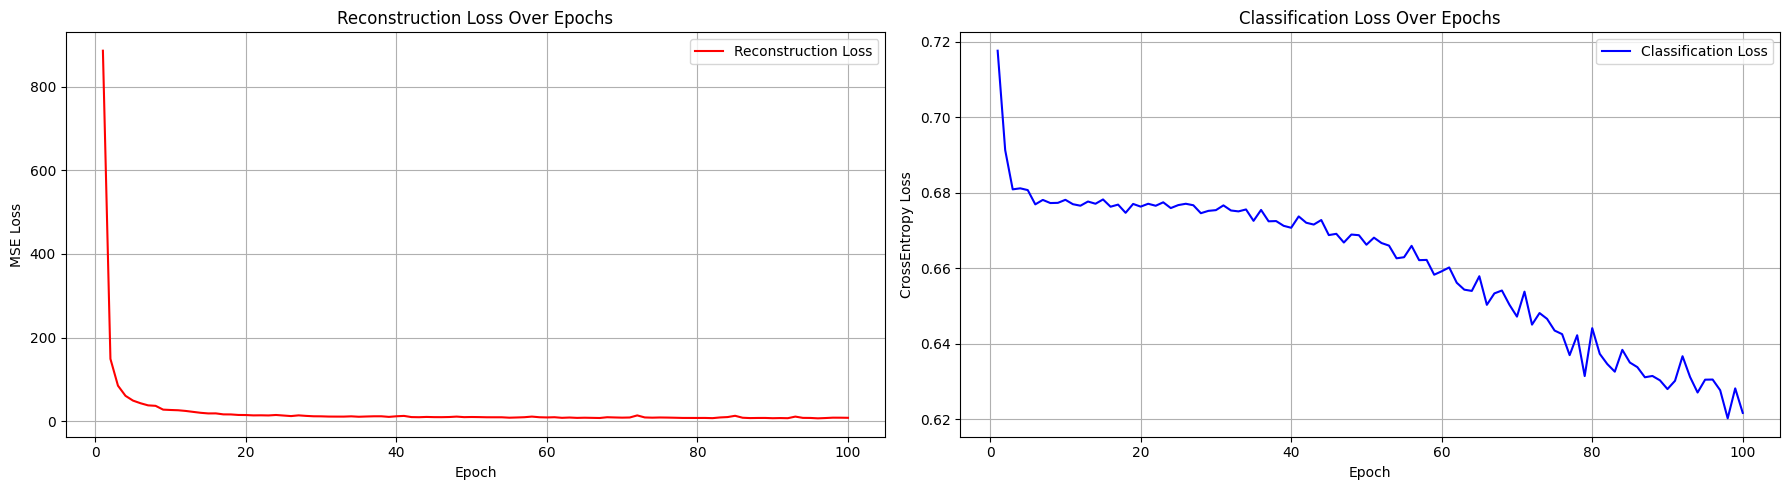

In [ ]:
# Plot the training history
plot_training_history(training_history)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

def evaluate_classifier(model, test_loader, device='cuda'):
    """
    Evaluates the classifier on the test dataset.

    Args:
        model (nn.Module): Combined autoencoder and classifier model.
        test_loader (DataLoader): DataLoader yielding (mel_spectrogram, label) batches.
        device (str): Device to perform computations on.

    Returns:
        None
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():

        for batch_spect, batch_tabular, mask, labels in tqdm(test_loader, desc='Evaluating'):
            batch_spect = batch_spect.to(device, non_blocking=True)
            batch_tabular = batch_tabular.to(device, non_blocking=True)
            mask = mask.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)       # Shape: (B,)

            _, class_logits = model(batch_spect, batch_tabular)
            _, predicted = torch.max(class_logits, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    print(f"Test AUC: {auc * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Evaluating: 100%|██████████| 55/55 [00:00<00:00, 109.50it/s]


Test Accuracy: 59.83%
Test AUC: 56.65%


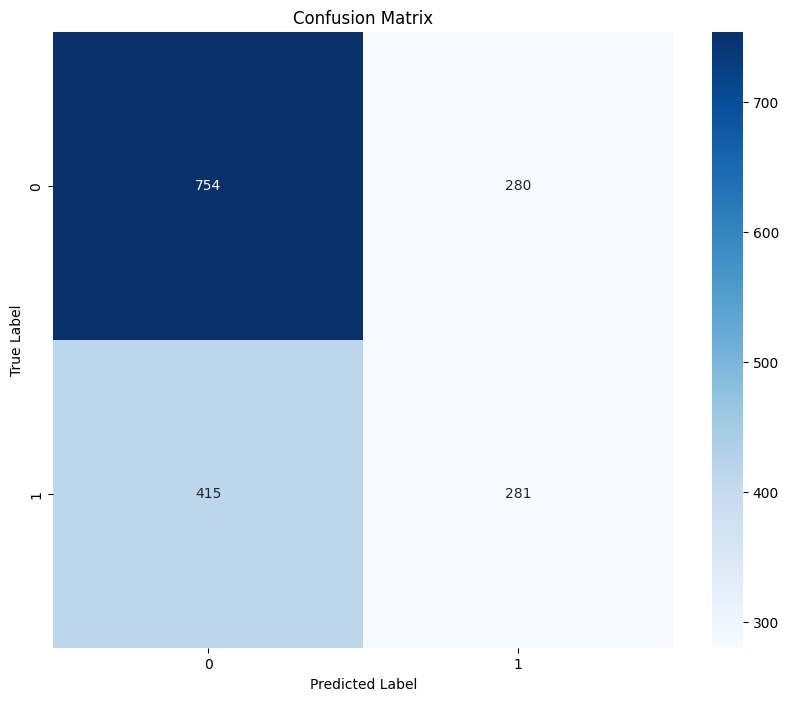

In [ ]:
evaluate_classifier(trained_model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

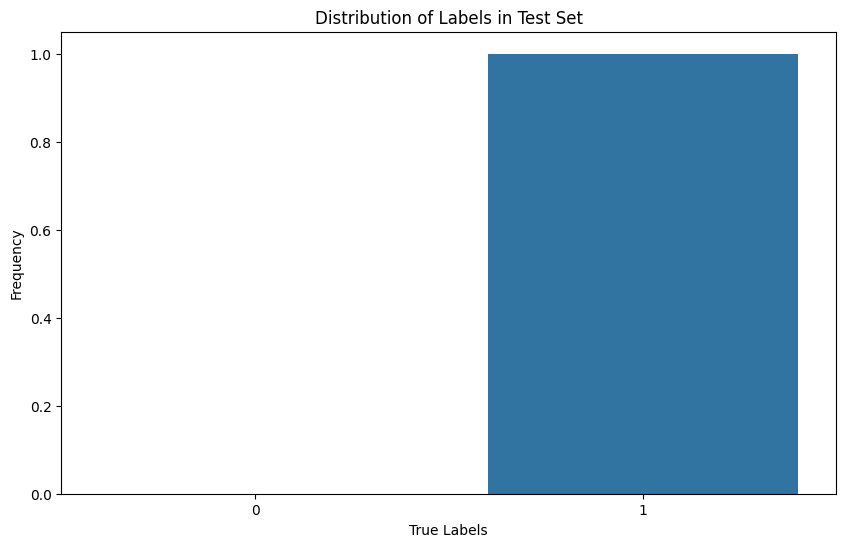

In [ ]:
# prompt: plot bsrplot labels_tensor[test_indices]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=labels_tensor[test_indices].cpu().numpy(), y=labels_tensor[test_indices].cpu().numpy()) # Assuming labels_tensor is a tensor
plt.xlabel("True Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Test Set")
plt.show()


In [ ]:
len(labels_tensor[test_indices]) - np.sum(labels_tensor[test_indices].cpu().numpy())

683

In [ ]:
def visualize_reconstructions_predictions(model, data_loader, device='cuda', num_examples=5):
    """
    Visualizes original vs. reconstructed Mel spectrograms and shows predictions.

    Args:
        model (nn.Module): Combined autoencoder and classifier model.
        data_loader (DataLoader): DataLoader for evaluation.
        device (str): Device to perform computations on.
        num_examples (int): Number of examples to visualize.
    """
    model.eval()
    examples = 0

    with torch.no_grad():
        for batch_data, mask, labels in data_loader:
            batch_data = batch_data.to(device)
            labels = labels.to(device)

            reconstructed, class_logits = model(batch_data)
            _, predicted = torch.max(class_logits, 1)

            batch_size = batch_data.size(0)
            for i in range(batch_size):
                if examples >= num_examples:
                    return
                original = batch_data[i].cpu().squeeze().numpy()
                recon = reconstructed[i].cpu().squeeze().numpy()
                true_label = labels[i].item()
                pred_label = predicted[i].item()

                # Plotting
                fig, axs = plt.subplots(1, 2, figsize=(18, 4))
                axs[0].imshow(original, aspect='auto', origin='lower', cmap='viridis')
                axs[0].set_title(f'Original Mel Spectrogram (Label: {true_label})')

                axs[1].imshow(recon, aspect='auto', origin='lower', cmap='viridis')
                axs[1].set_title(f'Reconstructed Mel Spectrogram (Pred: {pred_label})')


                plt.tight_layout()
                plt.show()

                examples += 1


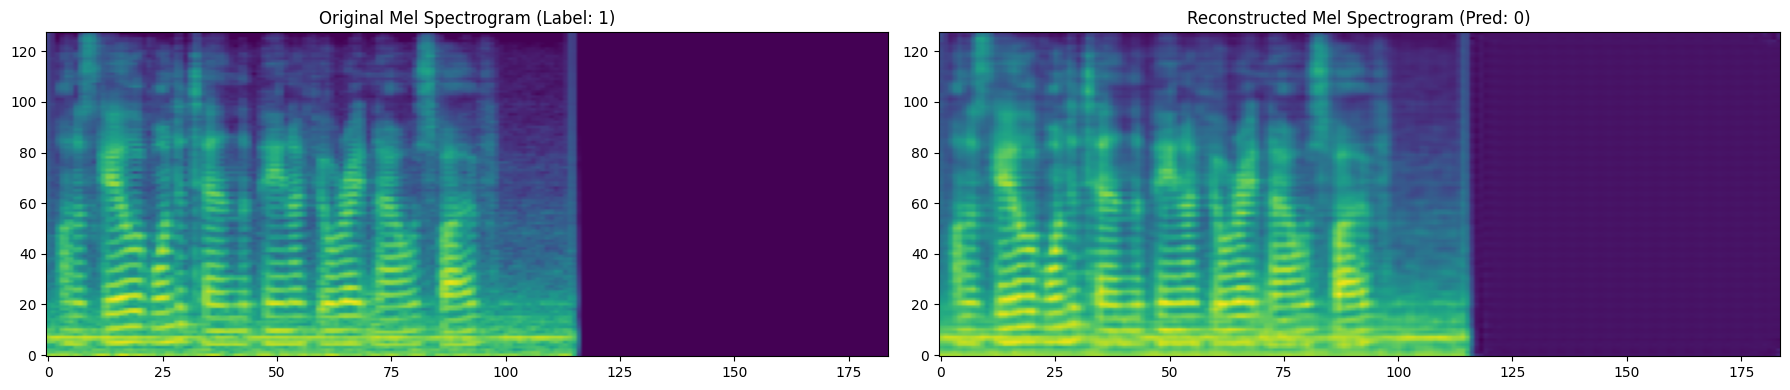

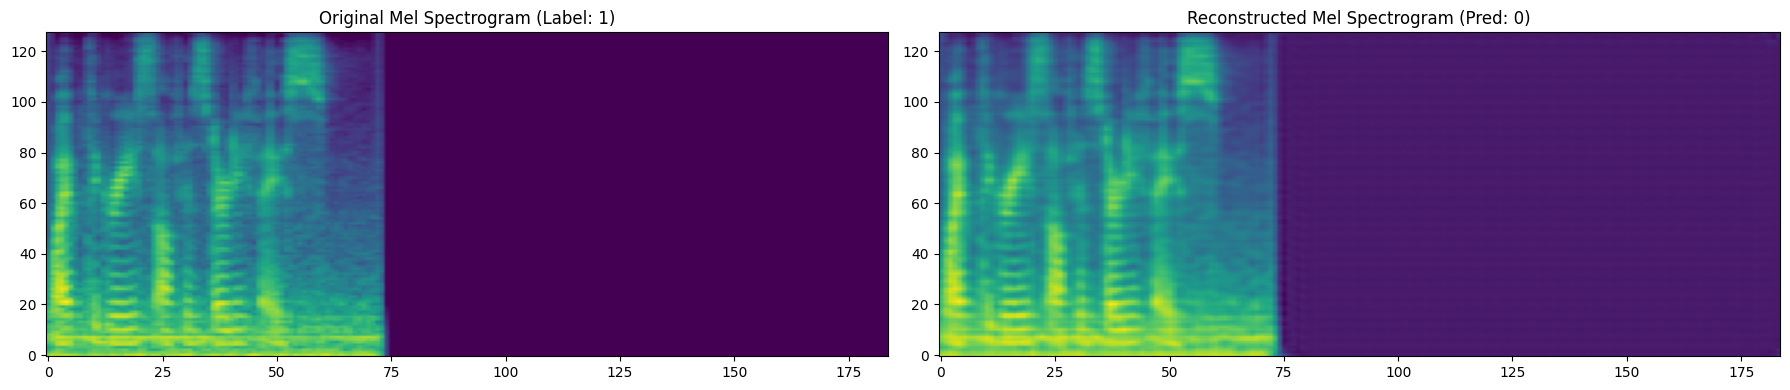

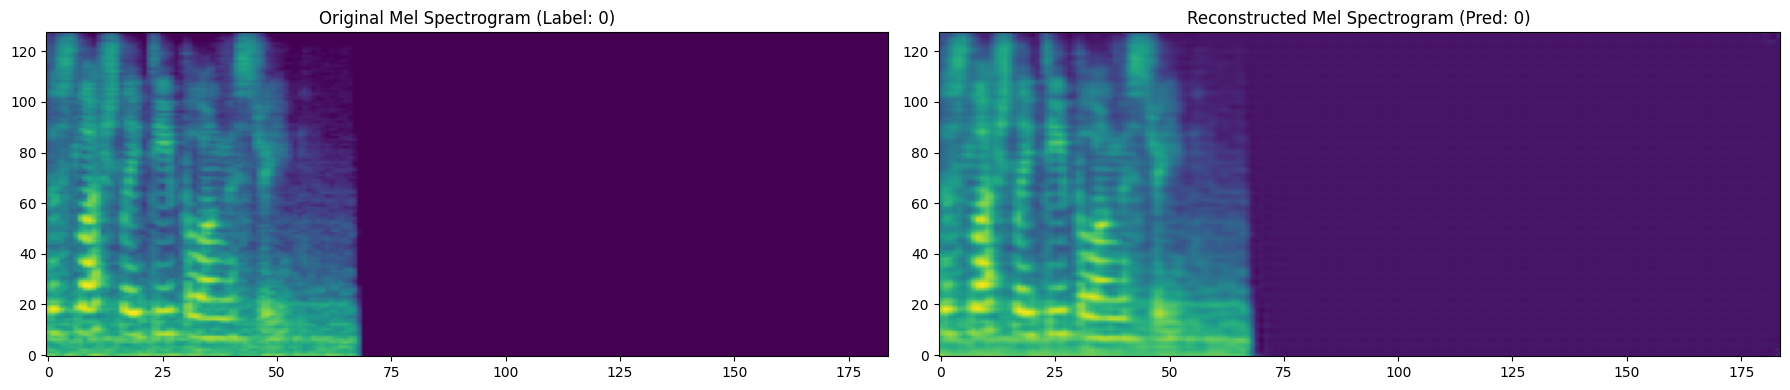

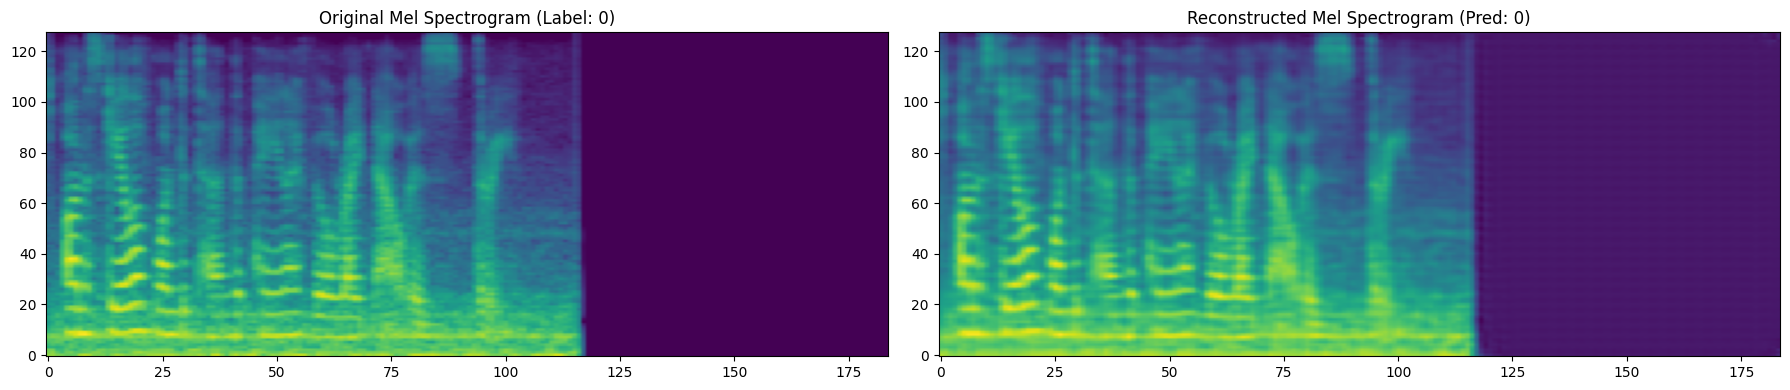

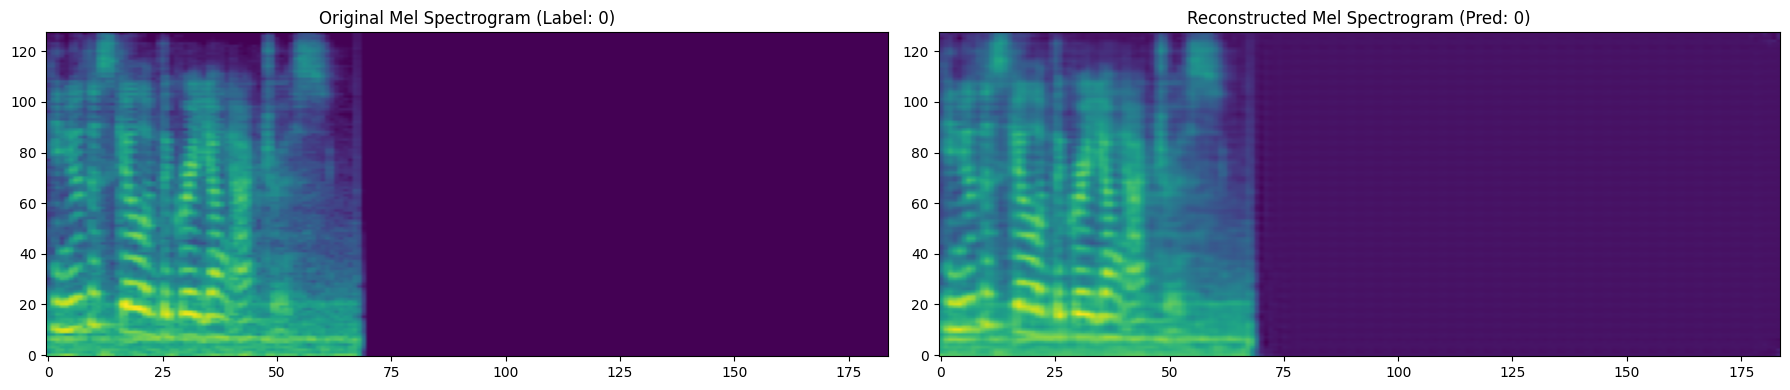

In [ ]:
# Visualize some reconstructions and predictions
visualize_reconstructions_predictions(trained_model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', num_examples=5)
